In [1]:
#!/usr/bin/env python
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import pprint
import json

import numpy as np
import pandas as pd
import obspy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time

from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"]= (15,15)
from matplotlib import rcParams, cycler
import matplotlib.colors as colors
from matplotlib import cm


import sys
import os
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3/'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.TimeAugmentor import TimeAugmentor
import json

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#%matplotlib notebook
helper = HelperFunctions()

In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.05,
    'balance_non_train_set' : True,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
full_ds, train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

2 2


In [3]:
earth_ds = full_ds[full_ds[:,1] == "earthquake"]
timeAug = TimeAugmentor(handler, earth_ds, loadData.seed)

### Observations:

 - Some events appear to contain multiple earthquakes (f.eks: /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2007-09-19T04.41.56.167000Z.h5, /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-04-15T19.20.09.574000Z.h5
 - Generally the onset of the earthquake is very weak, and after often over a minute later, the visually clear event occurs. This is very problematic wrt. the augmentation.
 - The labeled starttime is (for the ones I have seen) always at 1 minute after that start of the recording, and does not always correlate visually.
 

 

### Good candidates:

Events which start at the beginning of the waveform:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-04-15T19.20.09.574000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-10-24T03.04.11.895000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-01-07T04.18.26.039000Z.h5
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-02-24T10.49.54.603000Z.h5


Events which start at the middle of the waveform:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-08-16T16.01.20.125000Z.h5 (Starts after 1 minute, but the event of interest is most visible in the middle of the recording)

Events which start at the end of the waveform:
 
 
 #### Problematic datapoints:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-08-18T09.00.06.112000Z.h5 (No clear event)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2009-09-10T13.44.59.544000Z.h5 (Labeled start is before the start of the waveform)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2009-09-14T00.42.14.329000Z.h5 (indistinguishable from noise)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2019-12-12T00.06.11.688000Z.h5 (Event of interest appears to occur waay later than labeled. This leads to that part being cut out.

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-08-11T06.03.18.764000Z.h5 (too similar to noise)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-03-30T00.20.12.249000Z.h5 (Appears to start in the middle of an event. Does not seemingly contain noise during the first minute.)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-12-21T10.34.18.973000Z.h5 (Either mislabeled, or the labled event is not the most significant element of this recording)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2018-02-17T14.36.26.882000Z.h5 (Interesting event starts prior to the label)

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2018-04-25T00.07.09.622000Z.h5 (Event appears to occur near the end of the recording, not even close to the labeled time.)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2013-07-02T15.59.07.043000Z.h5 (Surface wave arrives in the last minute (2.5 mins after labeled P-wave)

 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2012-07-14T13.11.15.500000Z.h5 (Surface wave appears to arrive prior to the labeled event. Could also be explained by the recording starting during an ongoing stronger earthquake)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-04-18T06.55.43.356000Z.h5 (Same issue as above)
 
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-07-12T11.46.07.144000Z.h5 (Onset prior to label)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2014-07-16T04.23.13.411000Z.h5 (Indistinguishable from noise)

### Interesting datapoints
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2012-07-27T09.20.30.861000Z.h5 (Uncharacterstic in its strong onset)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2016-09-22T09.30.37.711000Z.h5 (Large difference between filtered and unfiltered. Huge manifestations when unfiltered.)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2006-08-09T07.42.00.079000Z.h5 (Clean, how I expected most of the data to look like)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2017-09-29T19.22.12.310000Z.h5 (Clean when unfiltered, a mess when filtered)
- /media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2010-06-09T16.57.12.583000Z.h5 (Same as above)


In [ ]:
i = 36

91
/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2015-09-04T16.53.14.961000Z.h5
2015-09-04 16:54:14.961000
1800


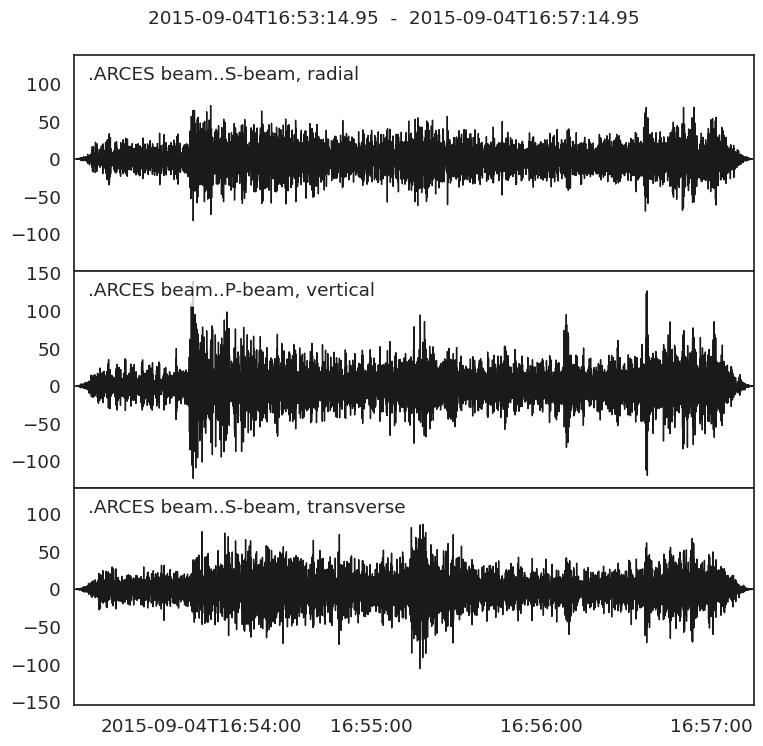

{   'analyst_pick_time': None,
    'az_to_arces': 105.83092224109679,
    'baz_to_arces': 305.4481360653561,
    'dist_to_arces': 824.1050406487107,
    'est_arrivaltime_arces': '2015-09-04 16:54:14.961000',
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.003642739519754564,
    'magnitude_sqrtdist_ratio': 0.10457296035927834,
    'magnitudes': [   {   'mag': 3.002,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/311df646-921a-4a70-891a-5ea40fcadbab',
                          'resource_id': 'smi:local/f269f94c-7531-4f1d-867c-9ac7662e5cc2'},
                      {   'mag': 2.52,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/311df646-921a-4a70-891a-5ea40fcadbab',
                          'resource_id': 'smi:local/9d73bb35-0498-4576-8a1f-5982a209e559'}],
    'origins': [   {   'arrivals': [   {   'azimuth': 311.21099,
             

In [185]:

candidates = [1, 2, 6, 7, 8, 10]
use_filter = True
print(i)
earth_path = earth_ds[i][0]
#earth_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-03-30T00.20.12.249000Z.h5'
print(earth_path)
trace, info = handler.path_to_trace(earth_path)
if use_filter:
    trace = np.array([trace])
    trace = handler.detrend_highpass_batch_trace(trace, True, True)
    trace = trace[0]
print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(earth_path)[0])
helper.plot_event(trace, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)
#i += 1



In [78]:
explo_ds = full_ds[full_ds[:,1] == "explosion"]
timeAug_explo = TimeAugmentor(handler, explo_ds, loadData.seed)

### Observations:

 - Appears to contain more "echo" than earthquakes, or multiple explosions at regular intervals. Likely not generally true
 

### Good candidates:
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2010-10-11T16.10.04.968000Z.h5 (Clean)
 - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2018-04-30T10.12.58.603000Z.h5 (More like what I expect)

 
 
 ### Problematic events:
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2013-06-10T14.03.22.128000Z.h5 (P-beam is off the charts, while the rest are not even close to the same magnitude)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2002-12-03T12.36.16.994000Z.h5 (Some event occuring during the first minute)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-06-01T10.42.13.807000Z.h5 (All beams are off the charts 
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2016-06-01T10.42.13.807000Z.h5 (same as above)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2017-04-08T15.52.19.641000Z.h5 (Multiple peaks, indicating several explosions. Strange due to the increasing intensity of each peak.)
  - /media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2012-01-21T10.10.24.865000Z.h5 (Clean with filter, but not without)
 

In [79]:
j = 0

56
/media/tord/T7/Thesis_ssd/norsar_data_nov/explosions/2010-04-09T08.56.40.554000Z.h5
2010-04-09 08:57:40.554000
2396


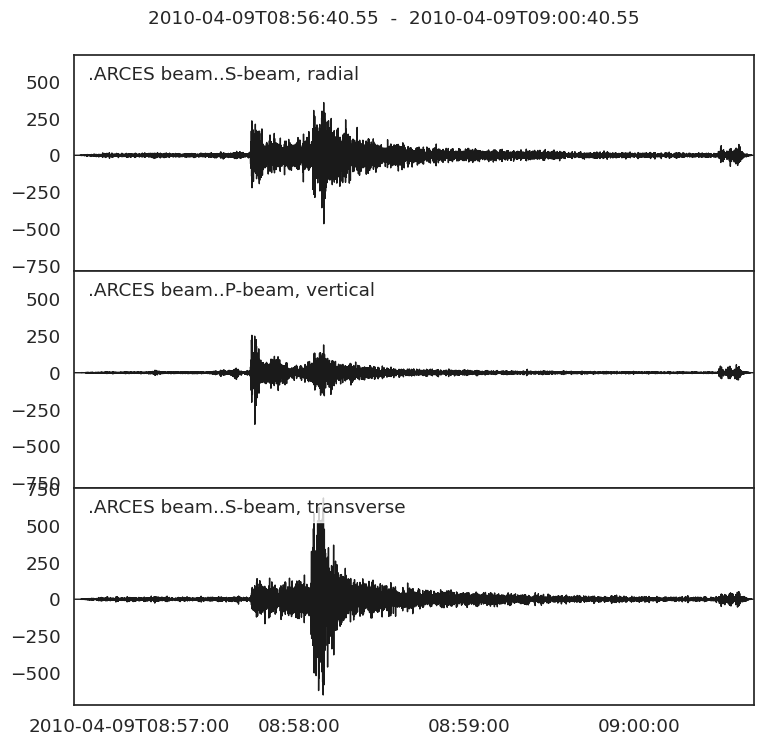

{   'analyst_pick_time': None,
    'az_to_arces': 1.7806494365058765,
    'baz_to_arces': 181.91298993072365,
    'comments': [   {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/a4bd1e6b-4fdf-4d52-85c9-8c6402c50c51',
                        'text': 'FULLY AUTOMATIC LOCATION, strong  P/S , good '
                                'locAtion'},
                    {   'creation_info': {'author': 'general'},
                        'resource_id': 'smi:local/133011d4-a064-46db-ae91-9ddfee6de10b',
                        'text': 'FINLAND'}],
    'dist_to_arces': 178.45382810344682,
    'est_arrivaltime_arces': '2010-04-09 08:57:40.554000',
    'event_type': 'explosion',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.006724428457227486,
    'magnitude_sqrtdist_ratio': 0.0898293612838975,
    'magnitudes': [   {   'creation_info': {'agency_id': 'HEL'},
                          'mag': 1.2,
                          'mag_errors': {

In [192]:
print(j)
candidates = [1, 2, 6, 7, 8, 10]
use_filter = True

explo_path = explo_ds[j][0]
#earth_path = '/media/tord/T7/Thesis_ssd/norsar_data_nov/earthquakes/2008-03-30T00.20.12.249000Z.h5'
print(explo_path)
trace, info = handler.path_to_trace(explo_path)
if use_filter:
    trace = np.array([trace])
    trace = handler.detrend_highpass_batch_trace(trace, True, True)
    trace = trace[0]
print(info['est_arrivaltime_arces'])
print(timeAug.find_initial_event_index(explo_path)[0])
helper.plot_event(trace, info)
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(info)

j += 1

